In [13]:
import batch_processor
import pickle
import numpy as np
from PIL import Image
with open('./output/dic_cont_arr.pkl', 'rb') as handle:
    dic_cont_arr = pickle.load(handle)

In [14]:
batch_data = batch_processor.DataPreProc(1,dic_cont_arr)

In [15]:
batches = batch_data.generate_batch()

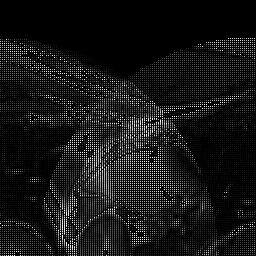

In [16]:
Image.fromarray( batches[0][0][0]['pixel_data'],mode = "L")

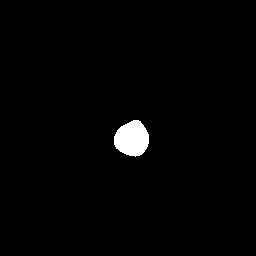

In [18]:
Image.fromarray(np.uint8(batches[0][0][1])*255)

In [62]:
im = Image.fromarray(np.uint8(batches[0][0][1]*255), mode = 'L')

In [63]:
im.putalpha( Image.fromarray( batches[0][0][0]['pixel_data'],mode = 'L'))